# Example-01: Derivative

In [1]:
# Given an input function, its higher order (partial) derivatives with respect to one or sevaral tensor arguments can be computed using forward or reverse mode automatic differentiation
# Derivative orders can be different for each tensor argument
# Input function is expected to return a tensor or a (nested) list of tensors

# Derivatives are computed by nesting torch.func jacobian functions
# For higher order derivatives, this results in growing redundant computations, forward mode is more efficient in this case

# If the input function returns a tensor, the output is referred as derivative table representation
# This representation can be evaluated near given evaluation point if the input function returns a scalar or a vector
# Table representation is a (nested) list of tensors, it can be used as a (redundant) function representation near given evaluation point
# Table structure for f(x), f(x, y) and f(x, y, z) is shown bellow (similar structure holds for a function with more aruments)

# f(x)
# t(f, x)
# [f, Dx f, Dxx f, ...]

# f(x, y)
# t(f, x, y)
# [
#     [    f,     Dy f,     Dyy f, ...],
#     [ Dx f,  Dx Dy f,  Dx Dyy f, ...],
#     [Dxx f, Dxx Dy f, Dxx Dyy f, ...],
#     ...
# ]

# f(x, y, z)
# t(f, x, y, z)
# [
#     [
#         [         f,          Dz f,          Dzz f, ...],
#         [      Dy f,       Dy Dz f,       Dy Dzz f, ...],
#         [     Dyy f,      Dyy Dz f,      Dyy Dzz f, ...],
#         ...
#     ],
#     [
#         [      Dx f,       Dx Dz f,       Dx Dzz f, ...],
#         [   Dx Dy f,    Dx Dy Dz f,    Dx Dy Dzz f, ...],
#         [  Dx Dyy f,   Dx Dyy Dz f,   Dx Dyy Dzz f, ...],
#         ...
#     ],
#     [
#         [    Dxx f,     Dxx Dz f,     Dxx Dzz f, ...],
#         [ Dxx Dy f,  Dxx Dy Dz f,  Dxx Dy Dzz f, ...],
#         [Dxx Dyy f, Dxx Dyy Dz f, Dxx Dyy Dzz f, ...],
#         ...
#     ],
#     ...
# ]

In [2]:
# Import

import torch

import sys
sys.path.append('..')

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Basic derivative interface

# nd.derivative(
#     order:int,                             # derivative order
#     function:Callable,                     # input function
#     *args,                                 # function(*args) = function(x:Tensor, ...)
#     intermediate:bool = True,              # flag to return intermediate derivatives
#     jacobian:Callable = torch.func.jacfwd  # torch.func.jacfwd or torch.func.jacfrev
# )

# nd.derivative(
#     order:tuple[int, ...],                 # derivative orders
#     function:Callable,                     # input function
#     *args,                                 # function(*args) = function(x:Tensor, y:Tensor, z:Tensor, ...)
#     intermediate:bool = True,              # flag to return intermediate derivatives
#     jacobian:Callable = torch.func.jacfwd  # torch.func.jacfwd or torch.func.jacfrev
# )

In [5]:
# Derivative

# Input:  scalar
# Output: scalar

# Set test function
# Note, the first function argument is a scalar tensor
# Input function can have other additional arguments
# Other arguments are not used in computation of derivatives

def fn(x, a, b, c, d, e, f):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

# Set derivative order

n = 5

# Set evaluation point

x = torch.tensor(0.0, dtype=dtype, device=device)

# Set fixed parameters

a, b, c, d, e, f = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=dtype, device=device)

# Compute n'th derivative

value = nd.derivative(n, fn, x, a, b, c, d, e, f, intermediate=False, jacobian=torch.func.jacfwd)
print(value.cpu().numpy().tolist())

# Compute all derivatives upto given order
# Note, function value itself is referred as zeros order derivative
# Since function returns a tensor, output is a list of tensors

values = nd.derivative(n, fn, x, a, b, c, d, e, f, intermediate=True, jacobian=torch.func.jacfwd)
print(*[value.cpu().numpy().tolist() for value in values], sep=', ')

# Note, intermediate flag (default=True) can be used to return all derivatives
# For jacobian parameter, torch.func.jacfwd or torch.func.jacrev functions can be passed

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor(1.0, dtype=dtype, device=device)
print(nd.evaluate(nd.derivative(n, fn, x, a, b, c, d, e, f) , [dx]).cpu().numpy().tolist())
print(fn(x + dx, a, b, c, d, e, f).cpu().numpy().tolist())

120.0
1.0, 1.0, 2.0, 6.0, 24.0, 120.0
6.0
6.0


In [6]:
# Derivative

# Input:  vector
# Output: scalar

# Set test function
# Note, the first function argument is a vector tensor
# Input function can have other additional arguments
# Other arguments are not used in computation of derivatives

def fn(x, a, b, c):
    x1, x2 = x
    return a + b*(x1 - 1)**2 + c*(x2 + 1)**2

# Set derivative order

n = 2

# Set evaluation point

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Set fixed parameters

a, b, c = torch.tensor([1.0, 1.0, 1.0], dtype=dtype, device=device)

# Compute only n'th derivative
# Note, for given input & output the result is hessian

value = nd.derivative(n, fn, x, a, b, c, intermediate=False, jacobian=torch.func.jacfwd)
print(value.cpu().numpy().tolist())

# Compute all derivatives upto given order
# Note, fuction value itself is referred as zeros order derivative
# Output is a list of tensors (value, jacobian, hessian, ...)

values = nd.derivative(n, fn, x, a, b, c, intermediate=True, jacobian=torch.func.jacfwd)
print(*[value.cpu().numpy().tolist() for value in values], sep=', ')

# Compute jacobian and hessian with torch.func

print(fn(x, a, b, c).cpu().numpy().tolist(), 
      torch.func.jacfwd(lambda x: fn(x, a, b, c))(x).cpu().numpy().tolist(), 
      torch.func.hessian(lambda x: fn(x, a, b, c))(x).cpu().numpy().tolist(), 
      sep=', ')

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor([+1.0, -1.0], dtype=dtype, device=device)
print(nd.evaluate(values, [dx]).cpu().numpy())
print(fn(x + dx, a, b, c).cpu().numpy())

# Evaluate can be mapped over a set of deviation values

print(torch.func.vmap(lambda x: nd.evaluate(values, [x]))(torch.stack(5*[dx])).cpu().numpy().tolist())

# Derivative can be mapped over a set of evaluation points
# Note, the inputt function is expeted to return a tensor

print(torch.func.vmap(lambda x: nd.derivative(1, fn, x, a, b, c, intermediate=False))(torch.stack(5*[x])).cpu().numpy().tolist())

[[2.0, 0.0], [0.0, 2.0]]
3.0, [-2.0, 2.0], [[2.0, 0.0], [0.0, 2.0]]
3.0, [-2.0, 2.0], [[2.0, 0.0], [0.0, 2.0]]
1.0
1.0
[1.0, 1.0, 1.0, 1.0, 1.0]
[[-2.0, 2.0], [-2.0, 2.0], [-2.0, 2.0], [-2.0, 2.0], [-2.0, 2.0]]


In [7]:
# Derivative

# Input:  vector
# Output: vector

# Set test function
# Note, the first function argument is a vector tensor
# Input function can have other additional arguments
# Other arguments (if any) are not used in computation of derivatives

def fn(x):
    x1, x2 = x
    X1 = 1.0*x1 + 2.0*x2
    X2 = 3.0*x1 + 4.0*x2
    X3 = 5.0*x1 + 6.0*x2
    return torch.stack([X1, X2, X3])

# Set derivative order

n = 1

# Set evaluation point

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Compute derivatives

values = nd.derivative(n, fn, x)
print(*[value.cpu().numpy().tolist() for value in values], sep=', ')
print()

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor([+1, -1], dtype=dtype, device=device)
print(nd.evaluate(values, [dx]).cpu().numpy().tolist())
print(fn(x + dx).cpu().numpy().tolist())

[0.0, 0.0, 0.0], [[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]]

[-1.0, -1.0, -1.0]
[-1.0, -1.0, -1.0]


In [8]:
# Derivative

# Input:  tensor
# Output: tensor

# Set test function

def fn(x):
    return 1 + x + x**2 + x**3

# Set derivative order

n = 3

# Set evaluation point

x = torch.zeros((1, 2, 3), dtype=dtype, device=device)

# Compute derivatives
# Note, output is a list of tensors

values = nd.derivative(n, fn, x)
print(*[list(value.shape) for value in values], sep='\n')

# Evaluate derivative table representation for a given deviation from the evaluation point
# Note, evaluate function works with scalar or vector tensor input
# One should compute derivatives of a wrapped function and reshape the result of evaluate

# Set wrapped function

def gn(x, shape):
    return fn(x.reshape(shape)).flatten()

print(fn(x).cpu().numpy().tolist())
print(gn(x.flatten(), x.shape).reshape(x.shape).cpu().numpy().tolist())

# Compute derivatives

values = nd.derivative(n, gn, x.flatten(), x.shape)

# Set deviation value

dx = torch.ones_like(x)

# Evaluate

print(nd.evaluate(values, [dx.flatten()]).reshape(x.shape).cpu().numpy().tolist())
print(gn((x + dx).flatten(), x.shape).reshape(x.shape).cpu().numpy().tolist())
print(fn(x + dx).cpu().numpy().tolist())

[1, 2, 3]
[1, 2, 3, 1, 2, 3]
[1, 2, 3, 1, 2, 3, 1, 2, 3]
[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]
[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]]
[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]]
[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0]]]
[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0]]]
[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0]]]


In [9]:
# Derivative

# Input:  vector
# Output: nested list of tensors

# Set test function

def fn(x):
    x1, x2, x3, x4, x5, x6 = x
    X1 = 1.0*x1 + 2.0*x2 + 3.0*x3
    X2 = 4.0*x4 + 5.0*x5 + 6.0*x6
    return [torch.stack([X1]), [torch.stack([X2])]]

# Set derivative order

n = 1

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

# Compute derivatives

values = nd.derivative(n, fn, x, intermediate=False)

In [10]:
# Derivative

# Input:  vector, vector, vector
# Output: vector

# Set test function

def fn(x, y, z):
    x1, x2 = x
    y1, y2 = y
    z1, z2 = z
    return torch.stack([(x1 + x2)*(y1 + y2)*(z1 + z2)])

# Set derivative orders for x, y and z

nx, ny, nz = 1, 1, 1

# Set evaluation point
# Note, evaluation point is a list of tensors

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
y = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
z = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Compute n'th derivativ

value = nd.derivative((nx, ny, nz), fn, x, y, z, intermediate=False)
print(value.cpu().numpy().tolist())

# Compute all derivatives upto given order

values = nd.derivative((nx, ny, nz), fn, x, y, z, intermediate=True)

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
dy = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
dz = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
print(nd.evaluate(values, [dx, dy, dz]).cpu().numpy().tolist())
print(fn(x + dx, y + dy, z + dz).cpu().numpy().tolist())

# Note, if the input function has vector arguments and returns a tensor, it can be repsented with series

for key, value in nd.series(tuple(map(len, (x, y, z))), (nx, ny, nz), values).items():
    print(f'{key}: {value.cpu().numpy().tolist()}')

[[[[1.0, 1.0], [1.0, 1.0]], [[1.0, 1.0], [1.0, 1.0]]]]
[8.0]
[8.0]
(0, 0, 0, 0, 0, 0): [0.0]
(0, 0, 0, 0, 1, 0): [0.0]
(0, 0, 0, 0, 0, 1): [0.0]
(0, 0, 1, 0, 0, 0): [0.0]
(0, 0, 0, 1, 0, 0): [0.0]
(0, 0, 1, 0, 1, 0): [0.0]
(0, 0, 1, 0, 0, 1): [0.0]
(0, 0, 0, 1, 1, 0): [0.0]
(0, 0, 0, 1, 0, 1): [0.0]
(1, 0, 0, 0, 0, 0): [0.0]
(0, 1, 0, 0, 0, 0): [0.0]
(1, 0, 0, 0, 1, 0): [0.0]
(1, 0, 0, 0, 0, 1): [0.0]
(0, 1, 0, 0, 1, 0): [0.0]
(0, 1, 0, 0, 0, 1): [0.0]
(1, 0, 1, 0, 0, 0): [0.0]
(1, 0, 0, 1, 0, 0): [0.0]
(0, 1, 1, 0, 0, 0): [0.0]
(0, 1, 0, 1, 0, 0): [0.0]
(1, 0, 1, 0, 1, 0): [1.0]
(1, 0, 1, 0, 0, 1): [1.0]
(1, 0, 0, 1, 1, 0): [1.0]
(1, 0, 0, 1, 0, 1): [1.0]
(0, 1, 1, 0, 1, 0): [1.0]
(0, 1, 1, 0, 0, 1): [1.0]
(0, 1, 0, 1, 1, 0): [1.0]
(0, 1, 0, 1, 0, 1): [1.0]


In [11]:
# Redundancy free computation

# Set test function

def fn(x):
    x1, x2 = x
    return torch.stack([1.0*x1 + 2.0*x2 + 3.0*x1**2 + 4.0*x1*x2 + 5.0*x2**2])

# Set derivative order

n = 2

# Set evaluation point

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Compute n'th derivative

value = nd.derivative(n, fn, x, intermediate=False)
print(value.cpu().numpy().tolist())

# Since derivatives are computed by nesting of jacobian function, redundant computations appear starting from the second order
# Redundant computations can be avoided if all input arguments are scalar tensors

def gn(x1, x2):
    return fn(torch.stack([x1, x2]))

print(nd.derivative((2, 0), gn, *x, intermediate=False).cpu().numpy().tolist())
print(nd.derivative((1, 1), gn, *x, intermediate=False).cpu().numpy().tolist())
print(nd.derivative((0, 2), gn, *x, intermediate=False).cpu().numpy().tolist())

[[[6.0, 4.0], [4.0, 10.0]]]
[6.0]
[4.0]
[10.0]


# Example-02: Derivative table representation

In [1]:
# Input function f: R^n x R^m x ... -> R^n is referred as a mapping
# The first function argument is state, other arguments (used in computation of derivatives) and knobs
# State and all knobs are vector-like tensors
# Note, functions of this form can be used to model tranformations throught accelerator magnets

# In this case, derivatives can be used to generate a (parametric) model of the input function
# Function model can be represented as a derivative table or coefficients of monomials (series representation)

# In this example, table representation is used to model transformation throught a sextupole accelerator magnet
# Table is computed with respect to state variables (phase space variables) and knobs (magnet strength and length)

In [2]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Mapping (sextupole accelerator magnet transformation)
# Given initial state, magnet strength and length, state is propagated using explicit symplectic integration
# Number of integration steps is set by count parameter, integration step length is length/count

def mapping(x, k, l, count=100):
    (qx, px, qy, py), (k, ), (l, ) = x, k, l/(2.0*count)
    for _ in range(count):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*k*(qx**2 - qy**2), py + 2.0*l*k*qx*qy
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py])

In [5]:
# Table representation (state)

# Set evaluation point & parameters

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
k = torch.tensor([10.0], dtype=dtype, device=device)
l = torch.tensor([0.1], dtype=dtype, device=device)

# Compute derivatives (table representation)
# Since derivatives are computed only with respect to the state, output table is a list of tensors

t = nd.derivative(6, mapping, x, k, l)

print(*[element.shape for element in t], sep='\n')

torch.Size([4])
torch.Size([4, 4])
torch.Size([4, 4, 4])
torch.Size([4, 4, 4, 4])
torch.Size([4, 4, 4, 4, 4])
torch.Size([4, 4, 4, 4, 4, 4])
torch.Size([4, 4, 4, 4, 4, 4, 4])


In [6]:
# Compare table and exact mapping near the evaluation point (change order to observe convergence)
# Note, table transformation is not symplectic

dx = torch.tensor([0.0, 0.001, 0.0001, 0.0], dtype=dtype, device=device)

print(nd.evaluate(t, [dx]).cpu().tolist())
print(mapping(x + dx, k, l).cpu().tolist())

[0.00010000041666220641, 0.001000006666736112, 0.00010000016667544442, 5.000018331681037e-09]
[0.00010000041666220632, 0.001000006666736112, 0.00010000016667544451, 5.000018331681034e-09]


In [7]:
# Each bottom element (tensor) in the (flattend) derivative table is assosiated with a signature
# Signature is a tuple of derivative orders

print(nd.signature(t))

[(0,), (1,), (2,), (3,), (4,), (5,), (6,)]


In [8]:
# For a given signature, corresponding element can be extracted or changed with get/set functions

print(nd.get(t, (1, )).cpu().numpy())

[[1.  0.1 0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.1]
 [0.  0.  0.  1. ]]


In [9]:
# Each bottom element is related to monomials
# For given order, monomial indices with repetitions can be computed
# These repetitions account for evaluation of the same partial derivatives with diffenent orders, e.g. df/dxdy vs df/dydx

print(nd.index(4, 2).cpu().numpy())

[[2 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [1 1 0 0]
 [0 2 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [1 0 1 0]
 [0 1 1 0]
 [0 0 2 0]
 [0 0 1 1]
 [1 0 0 1]
 [0 1 0 1]
 [0 0 1 1]
 [0 0 0 2]]


In [10]:
# Explicit evaluation

print(nd.evaluate(t, [dx]).cpu().numpy())
print((t[0] + t[1] @ dx + 1/2 * t[2] @ dx @ dx + 1/2 * 1/3 * t[3] @ dx @ dx @ dx + 1/2 * 1/3 * 1/4 * t[4] @ dx @ dx @ dx @ dx + 1/2 * 1/3 * 1/4 * 1/5 * t[5] @ dx @ dx @ dx @ dx @ dx + 1/2 * 1/3 * 1/4 * 1/5 * 1/6 * t[6] @ dx @ dx @ dx @ dx @ dx @ dx).cpu().numpy())
print((t[0] + (t[1] + 1/2 * (t[2] + 1/3 * (t[3] + 1/4 * (t[4] + 1/5 * (t[5] + 1/6 * t[6] @ dx) @ dx) @ dx) @ dx) @ dx) @ dx).cpu().numpy())

[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]
[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]
[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]


In [11]:
# Series representation can be generated from a given table
# This representation stores monomial powers and corresponding coefficients

s = nd.series((4, ), (6, ), t)
print(torch.stack([s[(1, 0, 0, 0)], s[(0, 1, 0, 0)], s[(0, 0, 1, 0)], s[(0, 0, 0, 1)]]).cpu().numpy())

[[1.  0.  0.  0. ]
 [0.1 1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.1 1. ]]


In [12]:
# Evaluate series

print(nd.evaluate(t, [dx]).cpu().numpy())
print(nd.evaluate(s, [dx]).cpu().numpy())

[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]
[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]


In [13]:
# Table representation (state & knobs)

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
k = torch.tensor([10.0], dtype=dtype, device=device)
l = torch.tensor([0.1], dtype=dtype, device=device)

# Compute derivatives (table representation)
# Since derivatives are computed with respect to state and knobs, output table is a nested list of tensors

t = nd.derivative((6, 1, 1), mapping, x, k, l)

In [14]:
# In this case, bottom table element signature is a tuple with several integers

print(nd.get(t, (1, 0, 0)).cpu().numpy())

[[1.  0.1 0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.1]
 [0.  0.  0.  1. ]]


In [15]:
# Compare table and exact mapping near evaluation point (change order to observe convergence)
# Note, table transofrmation is not symplectic

dx = torch.tensor([0.0, 0.001, 0.0001, 0.0], dtype=dtype, device=device)
dk = torch.tensor([0.1], dtype=dtype, device=device)
dl = torch.tensor([0.001], dtype=dtype, device=device)

print(nd.evaluate(t, [dx, 0.0*dk, 0.0*dl]).cpu().tolist())
print(nd.evaluate(t, [dx, 1.0*dk, 1.0*dl]).cpu().tolist())
print(mapping(x + dx, k + dk, l + dl).cpu().tolist())

[0.00010000041666220641, 0.001000006666736112, 0.00010000016667544442, 5.000018331681037e-09]
[0.00010100042756197639, 0.0010000067334053492, 0.0001000001733924745, 5.151019293264671e-09]
[0.00010100042756163604, 0.0010000067323920011, 0.0001000001734431457, 5.151524301990432e-09]


In [16]:
# Each bottom element (tensor) in the (flattend) derivative table is assosiated with a signature
# Signature is a tuple of derivative orders

print(*[index for index in nd.signature(t)], sep='\n')

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)
(2, 0, 0)
(2, 0, 1)
(2, 1, 0)
(2, 1, 1)
(3, 0, 0)
(3, 0, 1)
(3, 1, 0)
(3, 1, 1)
(4, 0, 0)
(4, 0, 1)
(4, 1, 0)
(4, 1, 1)
(5, 0, 0)
(5, 0, 1)
(5, 1, 0)
(5, 1, 1)
(6, 0, 0)
(6, 0, 1)
(6, 1, 0)
(6, 1, 1)


In [17]:
# Compute series

s = nd.series((4, 1, 1), (6, 1, 1), t)

# Keys are generalized monomials

print(s[(1, 1, 1, 1, 1, 1)].cpu().numpy())
print()

# Evaluate series

print(nd.evaluate(t, [dx, dk, dl]).cpu().numpy())
print(nd.evaluate(s, [dx, dk, dl]).cpu().numpy())
print()

[1.42877133e-06 9.99755017e-05 0.00000000e+00 0.00000000e+00]

[1.01000428e-04 1.00000673e-03 1.00000173e-04 5.15101929e-09]
[1.01000428e-04 1.00000673e-03 1.00000173e-04 5.15101929e-09]



# Example-03: Derivative table propagation

In [1]:
# Given a mapping f(state, *knobs, ...) and a derivative table t, derivatives of f(t, *knobs, ...) are computed
# This can be used to propagate derivative table throught a given mapping (computation of parametric fixed points and other applications)

In [2]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Define mappings

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=100):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def ring(x, w):
    x = quad(x, w, +0.25, 0.5)
    x = drif(x, w, 5.0)
    x = quad(x, w, -0.20, 0.5)
    x = quad(x, w, -0.20, 0.5)
    x = drif(x, w, 5.0)
    x = quad(x, w, +0.25, 0.5)
    return x

In [5]:
# Direct

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Compute derivatives

t = nd.derivative((1, 4), ring, x, w)

# Evaluate for a given deviation

dx = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
dw = torch.tensor([0.001], dtype=dtype, device=device)

print(ring(x + dx, w + dw).cpu().numpy())
print(nd.evaluate(t, [dx, dw]).cpu().numpy())

[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]
[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]


In [6]:
# Propagation

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Set identity table

t = nd.identity((1, 4), [x, w])

# Propagate table

t = nd.propagate((4, 1), (1, 4), t, [w], quad, +0.25, 0.5)
t = nd.propagate((4, 1), (1, 4), t, [w], drif, 5.0)
t = nd.propagate((4, 1), (1, 4), t, [w], quad, -0.20, 0.5)
t = nd.propagate((4, 1), (1, 4), t, [w], quad, -0.20, 0.5)
t = nd.propagate((4, 1), (1, 4), t, [w], drif, 5.0)
t = nd.propagate((4, 1), (1, 4), t, [w], quad, +0.25, 0.5)

# Evaluate for a given deviation

dx = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
dw = torch.tensor([0.001], dtype=dtype, device=device)

print(ring(x + dx, w + dw).cpu().numpy())
print(nd.evaluate(t, [dx, dw]).cpu().numpy())

[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]
[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]


In [7]:
# Series representation

s = nd.clean(nd.series((4, 1), (1, 4), t))
for key, value in s.items():
    print(f'{key}: {value.cpu().numpy()}')

(0, 1, 0, 0, 0): [18.26293553 -0.09072843  0.          0.        ]
(0, 0, 1, 0, 0): [ 0.          0.          0.49625858 -0.14063034]
(0, 0, 0, 1, 0): [0.         0.         5.35963583 0.49625858]
(1, 0, 0, 0, 1): [ 1.87420951 -0.09097396  0.          0.        ]
(0, 1, 0, 0, 1): [-24.33227046   1.87420951   0.           0.        ]
(0, 0, 1, 0, 1): [0.         0.         1.31324305 0.28161167]
(0, 0, 0, 1, 1): [0.         0.         1.46426265 1.31324305]
(1, 0, 0, 0, 2): [-2.65007558  0.18727838  0.          0.        ]
(0, 1, 0, 0, 2): [30.20570906 -2.65007558  0.          0.        ]
(1, 0, 0, 0, 3): [ 3.41796043 -0.28459189  0.          0.        ]
(0, 1, 0, 0, 3): [-35.88102956   3.41796043   0.           0.        ]
(0, 0, 1, 0, 3): [0.         0.         2.94802229 0.46018886]
(0, 0, 0, 1, 3): [ 0.          0.         15.6516443   2.94802229]
(1, 0, 0, 0, 4): [-4.17749922  0.38289808  0.          0.        ]
(0, 1, 0, 0, 4): [41.3560843  -4.17749922  0.          0.        ]


In [8]:
# Check invariant
# Note, ring has two quadratic invariants (actions), zeros are padded to match state length

# Define invariant

matrix = torch.tensor([[4.282355639365032, 0.0, 0.0, 0.0], [0.0, 0.23351633638449415, 0.0, 0.0], [0.0, 0.0, 2.484643367729646, 0.0], [0.0, 0.0, 0.0, 0.40247224732044934]], dtype=dtype, device=device)
def invariant(x):
    qx, px, qy, py = matrix.inverse() @ x
    return torch.stack([0.5*(qx**2 + px**2), 0.5*(qy**2 + py**2), *torch.tensor(2*[0.0], dtype=dtype, device=device)])

# Set evaluation point

x = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Evaluate invarint for a given state and transformed state

print(invariant(x).cpu().numpy())
print(invariant(ring(x, w)).cpu().numpy())

[2.72649397e-08 8.09919549e-08 0.00000000e+00 0.00000000e+00]
[2.72649397e-08 8.09919549e-08 0.00000000e+00 0.00000000e+00]


In [9]:
# Invariant propagation

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Compute table and series representations of invariant

t = nd.derivative((2, ), invariant, x)
s = nd.series((4, ), (2, ), t)

print(*[f'{key}: {value.cpu().numpy()}' for key, value in nd.clean(s, epsilon=1.0E-14).items()], sep='\n')
print()

# Compute table and series representations of transformed invariant

t = nd.derivative((2, ), lambda x: invariant(ring(x, w)), x)
s = nd.series((4, ), (2, ), t)

print(*[f'{key}: {value.cpu().numpy()}' for key, value in nd.clean(s, epsilon=1.0E-14).items()], sep='\n')
print()

# Propagate invariant

t = nd.derivative((2, ), ring, x, w)
t = nd.propagate((4, ), (2, ), t, [], invariant)
s = nd.series((4, ), (2, ), t)

print(*[f'{key}: {value.cpu().numpy()}' for key, value in nd.clean(s, epsilon=1.0E-14).items()], sep='\n')
print()

(2, 0, 0, 0): [0.02726494 0.         0.         0.        ]
(0, 2, 0, 0): [9.16928491 0.         0.         0.        ]
(0, 0, 2, 0): [0.         0.08099195 0.         0.        ]
(0, 0, 0, 2): [0.         3.08672633 0.         0.        ]

(2, 0, 0, 0): [0.02726494 0.         0.         0.        ]
(0, 2, 0, 0): [9.16928491 0.         0.         0.        ]
(0, 0, 2, 0): [0.         0.08099195 0.         0.        ]
(0, 0, 0, 2): [0.         3.08672633 0.         0.        ]

(2, 0, 0, 0): [0.02726494 0.         0.         0.        ]
(0, 2, 0, 0): [9.16928491 0.         0.         0.        ]
(0, 0, 2, 0): [0.         0.08099195 0.         0.        ]
(0, 0, 0, 2): [0.         3.08672633 0.         0.        ]



# Example-04: Jet class

In [1]:
# Jet is a convenience class to work with jets (evaluation point & derivative table)

In [2]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Define mappings

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=100):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Compute table representation

t = nd.derivative((1, 4), lambda x, w: quad(drif(x, w, 1.0), w, 1.0, 1.0, 1), x, w)

In [5]:
# Set jet

j = nd.Jet((4, 1), (1, 4), point=[x, w], dtype=dtype, device=device)
j = j.propagate(drif, 1.0)
j = j.propagate(quad, 1.0, 1.0, 1)

In [6]:
# Evaluate at given deviation

dx = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
dw = torch.tensor([0.001], dtype=dtype, device=device)

print(nd.evaluate(t, [dx, dw]).cpu().numpy())
print(j([dx, dw]).cpu().numpy())

[ 0.0005005 -0.001      0.0014995  0.001    ]
[ 0.0005005 -0.001      0.0014995  0.001    ]


In [7]:
# Composition

j1 = nd.Jet.from_mapping((4, 1), (1, 4), [x, w], drif, 1.0, dtype=dtype, device=device)
j2 = nd.Jet.from_mapping((4, 1), (1, 4), [x, w], quad, 1.0, 1.0, 1, dtype=dtype, device=device)

print((j1 @ j2)([dx, dw]).cpu().numpy())

[ 0.0005005 -0.001      0.0014995  0.001    ]


# Example-05: Nonlinear mapping approximation

In [1]:
# Composition of several nonlinear mappings can be approximated by its table representation

In [2]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set test mapping
# Rotation with two sextupoles separated by negative identity linear transformation
# Note, result is expected to have zero degree two coefficients due to negative identity linear transformation between sextupoles

def spin(x, mux, muy):
    (qx, px, qy, py), mux, muy = x, mux, muy
    return torch.stack([qx*mux.cos() + px*mux.sin(), px*mux.cos() - qx*mux.sin(), qy*muy.cos() + py*muy.sin(), py*muy.cos() - qy*muy.sin()])

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def sext(x, ks, l, n=1):
    (qx, px, qy, py), ks, l = x, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py])

def ring(x):
    mux, muy = 2.0*numpy.pi*torch.tensor([1/3 + 0.01, 1/4 + 0.01], dtype=dtype, device=device)
    x = spin(x, mux, muy)
    x = drif(x, -0.05)
    x = sext(x, 10.0, 0.1, 100)
    x = drif(x, -0.05)
    mux, muy = 2.0*numpy.pi*torch.tensor([0.50, 0.50], dtype=dtype, device=device)
    x = spin(x, mux, muy)
    x = drif(x, -0.05)
    x = sext(x, 10.0, 0.1, 100)
    x = drif(x, -0.05)
    return x

In [5]:
# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

# Compute derivative table

n = 4
t = nd.derivative(n, ring, x)

# Compute and print series

s = nd.clean(nd.series((4, ), (n, ), t), epsilon=1.0E-12)
print(*[f'{key}: {value.cpu().numpy()}' for key, value in nd.clean(s, epsilon=1.0E-14).items()], sep='\n')

(1, 0, 0, 0): [0.55339155 0.83292124 0.         0.        ]
(0, 1, 0, 0): [-0.83292124  0.55339155  0.          0.        ]
(0, 0, 1, 0): [0.         0.         0.06279052 0.99802673]
(0, 0, 0, 1): [ 0.          0.         -0.99802673  0.06279052]
(3, 0, 0, 0): [-7.53257307e-09  2.82424677e-03  0.00000000e+00  0.00000000e+00]
(2, 0, 1, 0): [ 0.00000000e+00 -0.00000000e+00  9.21186111e-06  3.34331441e-04]
(2, 0, 0, 1): [ 0.00000000e+00 -0.00000000e+00  1.59704766e-05 -5.06941449e-03]
(1, 2, 0, 0): [-1.11004920e-08  1.91940679e-02  0.00000000e+00  0.00000000e+00]
(1, 1, 0, 1): [ 0.00000000e+00 -0.00000000e+00 -1.48185697e-05  1.53623878e-02]
(1, 0, 2, 0): [-1.05857397e-06  1.97282603e-05  0.00000000e+00  0.00000000e+00]
(1, 0, 1, 1): [ 1.48154798e-05 -1.18570682e-03  0.00000000e+00  0.00000000e+00]
(1, 0, 0, 2): [2.88067554e-05 9.18409783e-03 0.00000000e+00 0.00000000e+00]
(0, 2, 1, 0): [ 0.00000000e+00 -0.00000000e+00  2.40366928e-05  7.09979811e-04]
(0, 1, 2, 0): [ 1.80396305e-06 -2.59

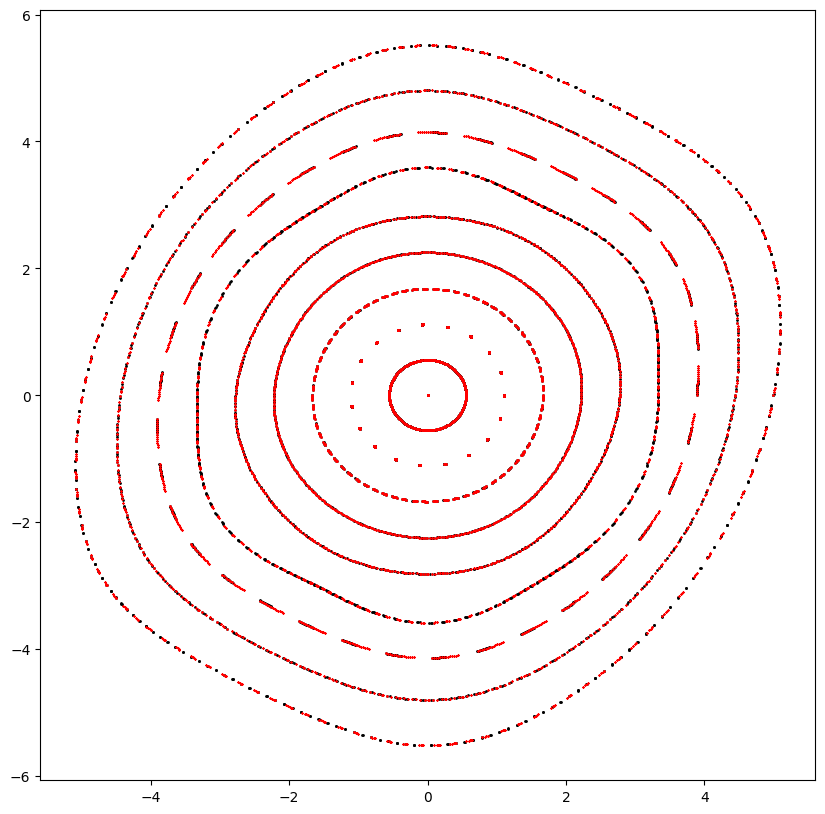

In [6]:
# Compare phase space trajectories
# Note, change order to observe convergence

plt.figure(figsize=(10, 10))

# Direct tracking

x = torch.linspace(0.0, 5.0, 10, dtype=dtype, device=device)
x = torch.stack([x, *3*[torch.zeros_like(x)]]).T

count = 512
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: ring(x))(x)

table = torch.stack(table).swapaxes(0, -1)
qx, px, *_ = table

for q, p in zip(qx.cpu().numpy(), px.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)

# Table tracking
# Note, table representation is not symplectic
    
x = torch.linspace(0.0, 5.0, 10, dtype=dtype, device=device)
x = torch.stack([x, *3*[torch.zeros_like(x)]]).T

count = 512
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: nd.evaluate(t, [x]))(x)

table = torch.stack(table).swapaxes(0, -1)
qx, px, *_ = table

for q, p in zip(qx.cpu().numpy(), px.cpu().numpy()):
    plt.scatter(q, p, color='red', marker='x', s=1)
    
plt.show()

# Example-06: Fixed point

In [1]:
# In this example fixed points are computed for a simple symplectic nonlinear transformation
# Fixed point are computed with Newton root search

In [2]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set forward & inverse mappings

mu = 2.0*numpy.pi*torch.tensor(1/3 - 0.01, dtype=dtype)
kq, ks, ko = torch.tensor([0.0, 0.25, -0.25], dtype=dtype)

def forward(x):
    q, p = x
    q, p = q*mu.cos() + p*mu.sin(), p*mu.cos() - q*mu.sin()
    q, p = q, p + (kq*q + ks*q**2 + ko*q**3)
    return torch.stack([q, p])

def inverse(x):
    q, p = x
    q, p = q, p - (kq*q + ks*q**2 + ko*q**3)
    q, p = q*mu.cos() - p*mu.sin(), p*mu.cos() + q*mu.sin()
    return torch.stack([q, p])

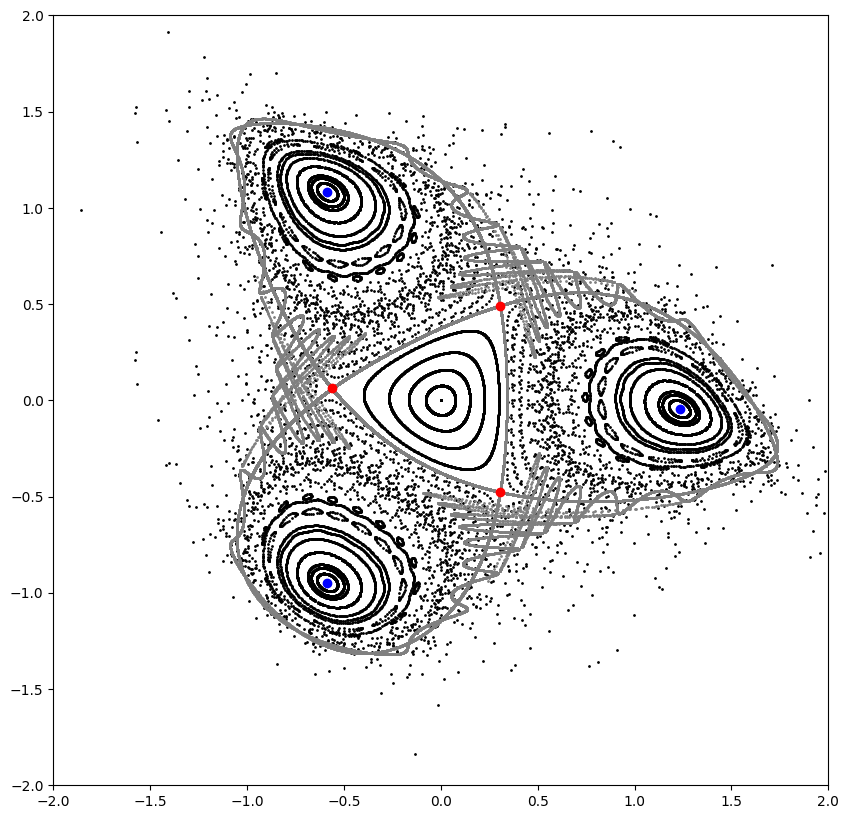

In [5]:
# Compute period three fixed points

# Set fixed point period

period = 3

# Set tolerance epsilon

epsilon = 1.0E-12

# Set random initial points

points = 4.0*torch.rand((128, 2), dtype=dtype, device=device) - 2.0

# Perform 512 root search iterations for each initial point

points = torch.func.vmap(lambda point: nd.fixed_point(512, forward, point, power=period))(points)

# Clean points (remove nans, duplicates, points from the same chain)

points = nd.clean_point(period, forward, points, epsilon=epsilon)

# Generate fixed point chains

chains = torch.func.vmap(lambda point: nd.chain_point(period, forward, point))(points)

# Classify fixed point chains (elliptic vs hyperbolic)
# Generate initials for hyperbolic fixed points using corresponding eigenvectors

kinds = []
for chain in chains:
    point, *_ = chain
    values, vectors = torch.linalg.eig(nd.matrix(period, forward, point))
    kind = all(values.log().real < epsilon)
    kinds.append(kind)
    if not kind:
        lines = [point + vector*torch.linspace(-epsilon, +epsilon, 1024, dtype=dtype).reshape(-1, 1) for vector in vectors.real.T]
        lines = torch.stack(lines)
        
# Plot phase space

x = torch.linspace(0.0, 1.5, 21, dtype=dtype, device=device)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: forward(x))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(10, 10))
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)

for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
# Plot (approximated) stable and unstable  manifolds of hyperbolic fixed points

count = 310

for line in lines:
    
    x = torch.clone(line)
    table = []
    for _ in range(count):
        table.append(x)
        x = torch.func.vmap(lambda x: forward(x))(x)
    table = torch.stack(table).swapaxes(0, -1)
    qs, ps = table
    for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
        plt.scatter(q, p, color='gray', marker='o', s=1)
        
    x = torch.clone(line)
    table = []
    for _ in range(count):
        table.append(x)
        x = torch.func.vmap(lambda x: inverse(x))(x)
    table = torch.stack(table).swapaxes(0, -1)
    qs, ps = table
    for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
        plt.scatter(q, p, color='gray', marker='o', s=1)
        
# Plot chains

for chain, kind in zip(chains, kinds):
    plt.scatter(*chain.T, color = {True:'blue', False:'red'}[kind], marker='o')

tensor([0., 0.], dtype=torch.float64)
tensor([-1.110223024625e-16,  0.000000000000e+00], dtype=torch.float64)


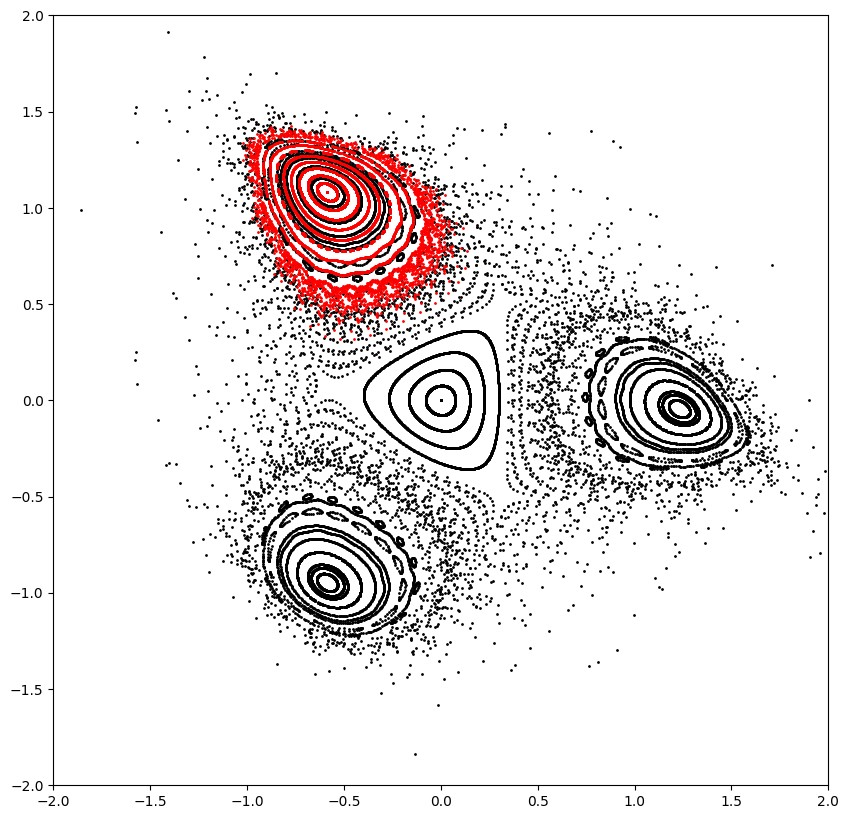

In [6]:
# Set mapping around elliptic fixed point

point, *_ = chains[kinds].squeeze()

def mapping(x):
    x = x + point
    for _ in range(period):
        x = forward(x)
    x = x - point
    return x

# Test mapping

x = torch.zeros_like(point)
print(x)
print(mapping(x))

# Plot phase space

x = torch.linspace(0.0, 1.5, 21, dtype=dtype, device=device)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: forward(x))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(10, 10))
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)

for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
x = torch.linspace(0.0, 0.5, 11, dtype=dtype, device=device)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: mapping(x))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table + point.reshape(2, 1, 1)

for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='red', marker='o', s=1)

# Example-07: Parametric fixed point

In [1]:
# Given a mapping depending on a set of knobs (parameters), parametric fixed points can be computed (position of a fixed point as function of parameters)
# Parametric fixed points can be used to construct responce matrices, e.g. closed orbit responce
# In this case only first order derivatives of the fixed point(s) with respect to parameters are computed
# Or higher order expansions can be computed
# In this example parametric fixed points of a symplectic mapping are computed

In [2]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set mapping

def mapping(x, k):
    q, p = x
    a, b = k
    q, p = q*mu.cos() + p*mu.sin(), p*mu.cos() - q*mu.sin()
    return torch.stack([q, p + a*q**2 + b*q**3])

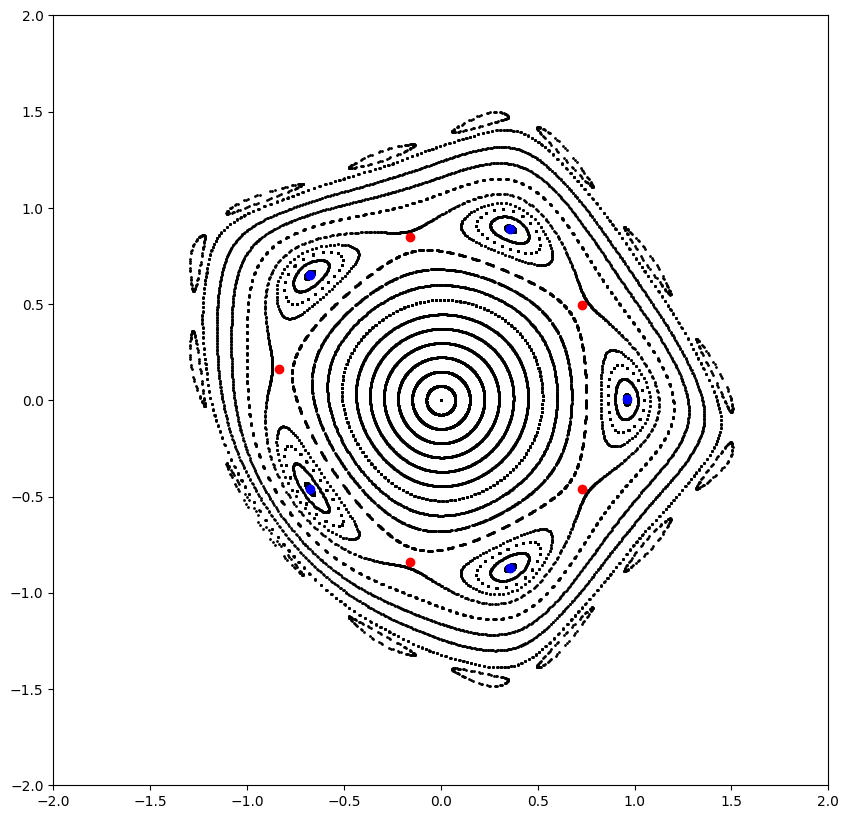

In [5]:
# Compute dynamical fixed points

# Set parameters

mu = 2.0*numpy.pi*torch.tensor(1/5 - 0.01, dtype=dtype, device=device)
k = torch.tensor([0.25, -0.25], dtype=dtype, device=device)

# Compute and plot phase space trajectories

x = torch.linspace(0.0, 1.5, 21, dtype=dtype)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []
for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: mapping(x, k))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(10, 10))
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)
for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
# Set tolerance epsilon
    
epsilon = 1.0E-12

# Compute chains
    
period = 5
points = 4.0*torch.rand((128, 2), dtype=dtype, device=device) - 2.0
points = torch.func.vmap(lambda point: nd.fixed_point(512, mapping, point, k, power=period))(points)
points = nd.clean_point(period, mapping, points, k, epsilon=epsilon)
chains = torch.func.vmap(lambda point: nd.chain_point(period, mapping, point, k))(points)

# Plot chains

for chain in chains:
    point, *_ = chain
    value, vector = torch.linalg.eig(nd.matrix(period, mapping, point, k))
    color = 'blue' if all(value.log().real < epsilon) else 'red'
    plt.scatter(*chain.T, color=color, marker='o')    
    if color == 'blue':
        ep, *_ = chain
    else:
        hp, *_ = chain
        
plt.show()

In [6]:
# Compute hyperbolic fixed point for a set of knobs

dks = torch.stack(2*[torch.linspace(0.0, 0.01, 101, dtype=dtype, device=device)]).T

fps = [hp]
for dk in dks:
    *_, initial = fps
    fps.append(nd.fixed_point(128, mapping, initial, k + dk, power=period))
    
fps = torch.stack(fps)

In [7]:
# Compute parametric fixed point

# Set computation order
# Note, change order to observe convergence

order = 4
pfp = nd.parametric_fixed_point((order, ), hp, [k], mapping, power=period)

# Set period mapping and check fixed point propagation

def function(x, k):
    for _ in range(period):
        x = mapping(x, k)
    return x

out = nd.propagate((2, 2), (0, order), pfp, [k], function)
for x, y in zip(nd.flatten(pfp, target=list), nd.flatten(out, target=list)):
    print(torch.allclose(x, y))

True
True
True
True
True


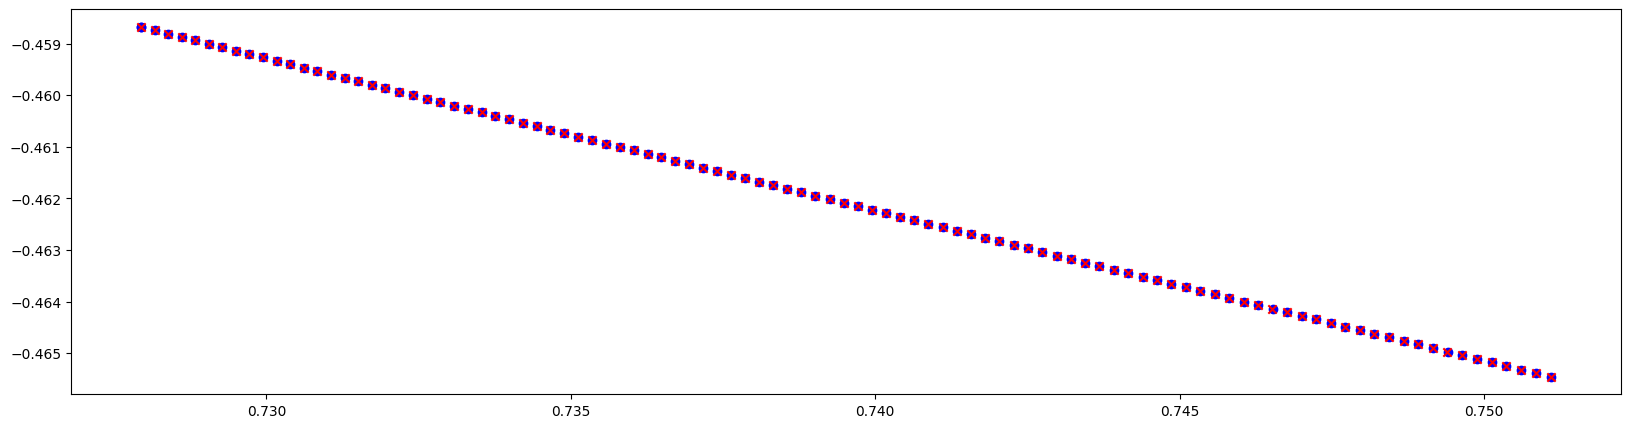

In [8]:
# Plot parametric fixed point position for a given set of knobs

out = torch.func.vmap(lambda dk: nd.evaluate(pfp, [hp, dk]))(dks)

plt.figure(figsize=(20, 5))
plt.scatter(*fps.T.cpu().numpy(), color='blue', marker='o')
plt.scatter(*out.T.cpu().numpy(), color='red', marker='x')
plt.show()